# Modeling
"Small" subsets Data from 
https://nijianmo.github.io/amazon/index.html (May 1996 - Oct 2018)

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

In [1]:
# Imports
import pandas as pd
import os
import yaml
import pickle

# String manipulation
import re
#conda install bs4
from bs4 import BeautifulSoup
import contractions
#conda install spacy
import spacy
#python -m spacy download en_core_web_sm
#pip install aspect_based_sentiment_analysis
import aspect_based_sentiment_analysis as absa

# Data visualisation
import matplotlib.pylab as plt
#import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

config = yaml.safe_load(open('config.yml'))

# Output folder
in_dir = config['in_dir']
out_dir = config['out_dir']


# Create the output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

d:\Users\camil\anaconda3\envs\absa_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading dataset
with open(os.path.join(in_dir, 'product_df.parquet'), 'rb') as handle:
        product_df = pd.read_parquet(handle)

#product_df = product_df.rename(columns={'reviewText':'text'})
product_df.reset_index(inplace=True)
product_df = product_df.rename(columns={'index':'review_id'})
product_df

,review_id,asin,overall,text,summary,date,style,vote,title,brand,main_cat,category,description,rank,price
0,15100,B000EPN8ZK,4.0,"after reading other reviews, I was hessitant t...",happliy surprised STILL GOING 2 YEARS LATER,2009-02-06,<NA>,14,4.6 Cu. Ft. Stainless Steel Refrigerator,Igloo,Amazon Home,"'Appliances', 'Refrigerators, Freezers & Ice M...",'FR465 Features: -Refrigerator.-Wire shelves.-...,"'>#292,893 in Kitchen & Dining (See Top 100 in...",
1,15101,B000EPN8ZK,5.0,"Best bang for my buck, Can't get a better deal...",The Fridge,2009-02-04,<NA>,3,4.6 Cu. Ft. Stainless Steel Refrigerator,Igloo,Amazon Home,"'Appliances', 'Refrigerators, Freezers & Ice M...",'FR465 Features: -Refrigerator.-Wire shelves.-...,"'>#292,893 in Kitchen & Dining (See Top 100 in...",
2,15102,B000EPN8ZK,1.0,"I did not read the reviews before purchasing, ...",DOA,2008-07-28,<NA>,50,4.6 Cu. Ft. Stainless Steel Refrigerator,Igloo,Amazon Home,"'Appliances', 'Refrigerators, Freezers & Ice M...",'FR465 Features: -Refrigerator.-Wire shelves.-...,"'>#292,893 in Kitchen & Dining (See Top 100 in...",
3,15103,B000EPN8ZK,1.0,Do not buy this item. Igloo refrigerators are ...,sucks,2007-07-31,<NA>,109,4.6 Cu. Ft. Stainless Steel Refrigerator,Igloo,Amazon Home,"'Appliances', 'Refrigerators, Freezers & Ice M...",'FR465 Features: -Refrigerator.-Wire shelves.-...,"'>#292,893 in Kitchen & Dining (See Top 100 in...",
4,15104,B000EPN8ZK,1.0,I purchased an Igloo refrigerator and within a...,Stay away from Igloo products!!,2006-08-18,<NA>,204,4.6 Cu. Ft. Stainless Steel Refrigerator,Igloo,Amazon Home,"'Appliances', 'Refrigerators, Freezers & Ice M...",'FR465 Features: -Refrigerator.-Wire shelves.-...,"'>#292,893 in Kitchen & Dining (See Top 100 in...",
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177,306123,B015YOHAK4,5.0,"Works well and efficient, realy keeps things ...",Five Stars,2015-08-06,<NA>,2,Igloo 3.2 cu. ft. 2-Door Refrigerator and Free...,Igloo,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...","""Keep your groceries fresh and your beverages ...","'>#4,219 in Appliances (See top 100)', '>#152 ...",
3178,306124,B015YOHAK4,5.0,Best having a separate freezer.,Five Stars,2014-09-06,<NA>,4,Igloo 3.2 cu. ft. 2-Door Refrigerator and Free...,Igloo,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...","""Keep your groceries fresh and your beverages ...","'>#4,219 in Appliances (See top 100)', '>#152 ...",
3179,306125,B015YOHAK4,5.0,Works well. But the fridge and freezer share s...,Not good,2014-09-02,<NA>,13,Igloo 3.2 cu. ft. 2-Door Refrigerator and Free...,Igloo,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...","""Keep your groceries fresh and your beverages ...","'>#4,219 in Appliances (See top 100)', '>#152 ...",
3180,306126,B015YOHAK4,5.0,Fridge got here super quick! Folks on the othe...,Fridge got here super quick! Folks on the othe...,2014-06-28,<NA>,6,Igloo 3.2 cu. ft. 2-Door Refrigerator and Free...,Igloo,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...","""Keep your groceries fresh and your beverages ...","'>#4,219 in Appliances (See top 100)', '>#152 ...",


In [3]:
# HTML tags removal
product_df['text']= product_df['text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

d:\Users\camil\anaconda3\envs\absa_env\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [4]:
# Limiting size of text due to memory overload

def break_row(df, col_name='text', max_chars = 525):
    """
    Split any rows in the given column of the given Pandas DataFrame that are
    longer than the specified number of characters at the end of a sentence or
    a space.
    
    Args:
        df (pandas.DataFrame): The DataFrame to modify.
        col_name (str): The name of the column to split.
        max_chars (int): The maximum number of characters allowed in each row.
    
    Returns:
        A new DataFrame with the specified column split into two if necessary.
    """
    new_df = pd.DataFrame(columns=df.columns)
    sentence_end_pattern = r"[.?!]"
    
    for index, row in df.iterrows():
        cell_contents = row[col_name]
        if len(cell_contents) > max_chars:
            # Split the cell contents at the end of a sentence or a space
            split_cells = re.findall(f"(.{{1,{max_chars}}}(?:(?:{sentence_end_pattern})|(?=\s)))\s?", cell_contents)
            new_row = row.copy()
            new_row[col_name] = split_cells[0]
            new_df = new_df.append(new_row)
            for split_cell in split_cells[1:]:
                new_row = row.copy()
                new_row[col_name] = split_cell.strip()
                new_df = new_df.append(new_row)
        else:
            new_df = new_df.append(row)
    
    return new_df

product_df = break_row(product_df)


In [5]:
# Reducing top top 10 products
product_df = product_df[product_df['asin']\
                        .isin(list(product_df.value_counts('asin').head(10).index))]
product_df.reset_index(inplace=True)

product_df.shape

## Aspect Extraction

### Rule based

In [7]:
from textblob import TextBlob

nlp = spacy.load('en_core_web_sm')
nlp.Defaults.stop_words |= {'one','unit', 'part', 'item', 'thing', 'review', 'stuff'}

def clean_text(text, stop_words = nlp.Defaults.stop_words, nlp = nlp, TextBlob = TextBlob, contractions = contractions):
    '''
    Return text with the modifications:
    Normalization (lowercase), Removal of unwanted characters and stopwords and lemmatization
    ''' 
    # Tabs
    #text = re.sub(r"[\n][\t]*|[\t]", " ", text) 
    # HTML tags removal
    #text = BeautifulSoup(text, 'html.parser').get_text()
    # Normalization (lowercase)
    text = text.lower()
    # Removing mentions (@person) and Hashtags #topic, 
    #text = re.sub(r"(@|#\ z0-9]+)|([^0-9A-Za-z \t])|^rt", "", text)
    # Links: http://
    #text = re.sub(r"https?:\/\/.*[\r\n]*", "", text, flags=re.MULTILINE) 
    # Contractions
    text = contractions.fix(text)
    # Removal of unwanted characters
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', '', text)
    # Numbers
    text = re.sub(r"[0-9]", "",text)
    # too long words: Incomprehensibilities is longest word “in common usage" or single letters
    text = re.sub(r"\b\w{25,90}\b|\b\w{1}\b", "",text)
    
    # Spelling correction
    text = str(TextBlob(text).correct())

    # Lemmatization
    lemmatized = []
     
    doc = nlp(text)
    for token in doc:
        lemmatized.append(token.lemma_)
    
    # Removing Stopwords
    if stop_words:    
        text = " ".join([word for word in lemmatized if word not in (stop_words)])
    text = re.sub(r'\s+',' ',text)
        
    return text.strip()

In [11]:
def get_absa(text, nlp=nlp):
    '''
    Aspect based Sentiment Analysis
    Input:  text as a string
            Spacy's nlp
    Output: For each noun get the list of Adjectives and their adverbs

    '''
    doc = nlp(text)
    aspects = []
    for sentence in doc.sents:
        description = ''
        aspect = ''
        for token in sentence:
            if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
                aspect = token.text
            if token.pos_ == 'ADJ':
                prepend = ''
                for child in token.children:
                    if child.pos_ != 'ADV':
                        continue
                    prepend += child.text + ' '
                description = prepend + token.text
        if (aspect != '' or description != ''):
            aspects.append({'aspect': aspect,'description': description})
    return aspects

In [12]:
#12min
# Text Cleaning
product_df['text_clean'] = product_df['text'].apply(lambda text: clean_text(text))

In [13]:
# Aspect Based Sentiment Analysis
product_df['absa_rule'] = product_df['text_clean'].apply(lambda text: get_absa(text))

product_df.head()

,index,review_id,asin,overall,text,summary,date,style,vote,title,brand,main_cat,category,description,rank,price,text_clean,absa_rule
0,304,52328,B0037X9990,5.0,I purchased this from Sears with good discount...,"Pleasant refrigirator, awesome design, large a...",2011-03-09,<NA>,16,Bosch B26FT70SNS800 25.9 Cu. Ft. Stainless Ste...,Bosch,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...",'800 25.9 Cu. Ft. Stainless Steel French Door ...,"'>#18,538 in Appliances (See top 100)', '>#985...",,purchase sear good discount happy cost schedul...,"[{'aspect': 'folk', 'description': 'instal'}]"
1,304,52328,B0037X9990,5.0,PROS:,"Pleasant refrigirator, awesome design, large a...",2011-03-09,<NA>,16,Bosch B26FT70SNS800 25.9 Cu. Ft. Stainless Ste...,Bosch,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...",'800 25.9 Cu. Ft. Stainless Steel French Door ...,"'>#18,538 in Appliances (See top 100)', '>#985...",,pro,"[{'aspect': '', 'description': 'pro'}]"
2,304,52328,B0037X9990,5.0,"1-Looks, it makes your kitchen a lot more sell...","Pleasant refrigirator, awesome design, large a...",2011-03-09,<NA>,16,Bosch B26FT70SNS800 25.9 Cu. Ft. Stainless Ste...,Bosch,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...",'800 25.9 Cu. Ft. Stainless Steel French Door ...,"'>#18,538 in Appliances (See top 100)', '>#985...",,look kitchen lot syllable ready hot,"[{'aspect': '', 'description': 'hot'}]"
3,304,52328,B0037X9990,5.0,2-Inside is roomy,"Pleasant refrigirator, awesome design, large a...",2011-03-09,<NA>,16,Bosch B26FT70SNS800 25.9 Cu. Ft. Stainless Ste...,Bosch,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...",'800 25.9 Cu. Ft. Stainless Steel French Door ...,"'>#18,538 in Appliances (See top 100)', '>#985...",,inside room,"[{'aspect': '', 'description': 'inside'}]"
4,304,52328,B0037X9990,5.0,3-Well lit,"Pleasant refrigirator, awesome design, large a...",2011-03-09,<NA>,16,Bosch B26FT70SNS800 25.9 Cu. Ft. Stainless Ste...,Bosch,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...",'800 25.9 Cu. Ft. Stainless Steel French Door ...,"'>#18,538 in Appliances (See top 100)', '>#985...",,light,"[{'aspect': '', 'description': 'light'}]"


In [14]:
# Dataframe for each aspect
absa_df = pd.DataFrame()
for i, row in enumerate(product_df['absa_rule']):
  absa_df_new = pd.DataFrame.from_records(row)
  absa_df_new['index'] = i
  
  absa_df = pd.concat([absa_df, absa_df_new], ignore_index=True)

# Aspects's description per rule based method
aspects_rule_based_df = absa_df.groupby(['aspect'])['description'].apply(lambda x: ', '.join(x))
# Save
aspects_rule_based_df.to_csv(os.path.join(out_dir, 'aspects_rule_based_df.csv'), sep=';', index=False)
aspects_rule_based_df
  

aspect
             pro, hot, inside, light, flexible, large, orde...
ability                                                 frozen
adjust                                                  single
advantage                                                angry
affair                                                   ahead
                                   ...                        
wish                                       cold, super, modern
woman                         overall perfect, overall perfect
work         dripping, slightly loud, quickly great, inner,...
world                                                      new
year         poor, great, ok, extensive, dead good, bad, worth
Name: description, Length: 507, dtype: object

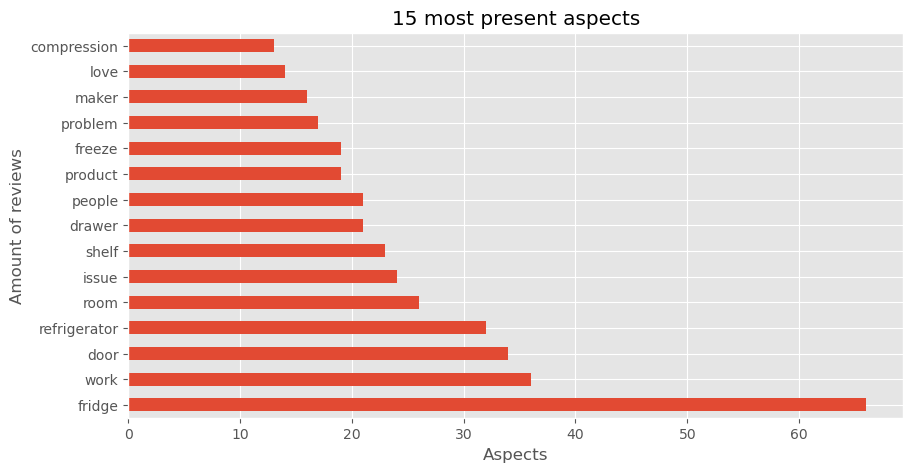

In [15]:
ax = absa_df['aspect'].value_counts().sort_values(ascending=False)[1:16] \
    .plot(kind='barh',
          title='15 most present aspects',
          figsize=(10, 5))
ax.set_xlabel('Aspects')
ax.set_ylabel('Amount of reviews')
plt.show()

In [16]:
# List of aspects: list comprehension is faster than vectorisation 
#https://stackoverflow.com/questions/54028199/are-for-loops-in-pandas-really-bad-when-should-i-care/54028200#54028200
product_df['aspect'] = product_df['absa_rule'].apply(lambda x: [i['aspect'] for i in x if len(i['aspect'])>1 ])
# Remove repeated aspects
product_df['aspect'] = product_df['aspect'].apply(lambda x: list(dict.fromkeys(x)))
# Filling in when aspect is not found
#product_df['aspect'] = product_df['aspect'].apply(lambda x: ['product'] if len(x)==0 else x)
# Removing when aspect is not found
product_df = product_df[product_df['aspect'].map(len) >0]
# Limiting size of text due to memory overload
#product_df['text'] = product_df['text'].apply(lambda text: text[:525])

product_df.shape


(1403, 19)

In [18]:
# Limiting to top 25 products
top_list = list(product_df['asin'].value_counts().index)[:25]
product_df = product_df[product_df['asin'].isin(top_list)]
product_df.shape

(1403, 19)

In [19]:
# From https://rafalrolczynski.com/2021/03/07/aspect-based-sentiment-analysis/
nlp_absa = absa.load()

Some layers from the model checkpoint at absa/classifier-rest-0.2 were not used when initializing BertABSClassifier: ['dropout_379']
- This IS expected if you are initializing BertABSClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertABSClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertABSClassifier were not initialized from the model checkpoint at absa/classifier-rest-0.2 and are newly initialized: ['dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# 80min
product_df['absa'] = product_df.apply(lambda x: nlp_absa(text=x['text'], aspects=x['aspect']), axis=1)

# Saving
try:
    product_df.drop(columns='absa').to_parquet(os.path.join(out_dir, 'product_df.parquet'))
except:
    print('Saved as pickle and csv')
    product_df.to_pickle(os.path.join(out_dir, 'product_df.pickle'))
    product_df.to_csv(os.path.join(out_dir, 'product_df.csv'))
    product_df.drop(columns='absa').to_parquet(os.path.join(out_dir, 'product_df_.parquet'))

product_df.head()

Saved as pickle and csv


,index,review_id,asin,overall,text,summary,date,style,vote,title,brand,main_cat,category,description,rank,price,text_clean,absa_rule,aspect,absa
0,304,52328,B0037X9990,5.0,I purchased this from Sears with good discount...,"Pleasant refrigirator, awesome design, large a...",2011-03-09,<NA>,16,Bosch B26FT70SNS800 25.9 Cu. Ft. Stainless Ste...,Bosch,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...",'800 25.9 Cu. Ft. Stainless Steel French Door ...,"'>#18,538 in Appliances (See top 100)', '>#985...",,purchase sear good discount happy cost schedul...,"[{'aspect': 'folk', 'description': 'instal'}]",[folk],CompletedTask(text='I purchased this from Sear...
5,304,52328,B0037X9990,5.0,4-Ice and water outlet is flat and looks very ...,"Pleasant refrigirator, awesome design, large a...",2011-03-09,<NA>,16,Bosch B26FT70SNS800 25.9 Cu. Ft. Stainless Ste...,Bosch,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...",'800 25.9 Cu. Ft. Stainless Steel French Door ...,"'>#18,538 in Appliances (See top 100)', '>#985...",,ice water outlet flat look modern touch sensit...,"[{'aspect': 'button', 'description': 'sensitiv...",[button],CompletedTask(text='4-Ice and water outlet is ...
6,304,52328,B0037X9990,5.0,5-Water coming out of the dispenser is filtere...,"Pleasant refrigirator, awesome design, large a...",2011-03-09,<NA>,16,Bosch B26FT70SNS800 25.9 Cu. Ft. Stainless Ste...,Bosch,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...",'800 25.9 Cu. Ft. Stainless Steel French Door ...,"'>#18,538 in Appliances (See top 100)', '>#985...",,water come dispense filter pleasant taste filt...,"[{'aspect': 'water', 'description': 'small'}]",[water],"CompletedTask(text=""5-Water coming out of the ..."
10,304,52328,B0037X9990,5.0,9-External light is pleasantly lit and ambient...,"Pleasant refrigirator, awesome design, large a...",2011-03-09,<NA>,16,Bosch B26FT70SNS800 25.9 Cu. Ft. Stainless Ste...,Bosch,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...",'800 25.9 Cu. Ft. Stainless Steel French Door ...,"'>#18,538 in Appliances (See top 100)', '>#985...",,external light pleasantly light absent find wa...,"[{'aspect': 'light', 'description': 'blue'}]",[light],CompletedTask(text='9-External light is pleasa...
11,304,52328,B0037X9990,5.0,10-The Ice maker does not take the entire insi...,"Pleasant refrigirator, awesome design, large a...",2011-03-09,<NA>,16,Bosch B26FT70SNS800 25.9 Cu. Ft. Stainless Ste...,Bosch,Appliances,"'Appliances', 'Refrigerators, Freezers & Ice M...",'800 25.9 Cu. Ft. Stainless Steel French Door ...,"'>#18,538 in Appliances (See top 100)', '>#985...",,ice maker entire inside section right door ice...,"[{'aspect': 'maker', 'description': 'dedicate'}]",[maker],CompletedTask(text='10-The Ice maker does not ...


In [22]:
# Expanding per aspect
result_df = pd.DataFrame()

for index, row in product_df.iterrows():
  for example in row['absa'].examples:
    new_row = {
    'review_id': row['review_id'],
    'asin': row['asin'],
    'text': row['text'],
    'overall': row['overall'],
    'aspect': example.aspect,
    'sentiment':  example.sentiment,
    'positive': example.scores[0],
    'negative': example.scores[1],
    'neutral': example.scores[2],
    }
    new_row = pd.DataFrame.from_dict(new_row, orient='index').T
    result_df = pd.concat([result_df, new_row], axis=0, ignore_index=True)

result_df.to_parquet(os.path.join(out_dir, 'result_df.parquet'))

result_df.head()

,review_id,asin,text,overall,aspect,sentiment,positive,negative,neutral
0,52328,B0037X9990,I purchased this from Sears with good discount...,5.0,folk,Sentiment.positive,0.270726,0.289525,0.439749
1,52328,B0037X9990,4-Ice and water outlet is flat and looks very ...,5.0,button,Sentiment.neutral,0.846538,0.066063,0.087399
2,52328,B0037X9990,5-Water coming out of the dispenser is filtere...,5.0,water,Sentiment.positive,0.031876,0.008306,0.959817
3,52328,B0037X9990,9-External light is pleasantly lit and ambient...,5.0,light,Sentiment.positive,0.00045,0.001447,0.998103
4,52328,B0037X9990,10-The Ice maker does not take the entire insi...,5.0,maker,Sentiment.negative,0.147685,0.745861,0.106454


from transformers import BertTokenizer
#!spacy download en_core_web_sm
import aspect_based_sentiment_analysis as absa
from aspect_based_sentiment_analysis import Professor

recognizer = absa.aux_models.BasicPatternRecognizer()
name = 'absa/classifier-rest-0.2'
model = absa.BertABSClassifier.from_pretrained(name)
tokenizer = BertTokenizer.from_pretrained(name)
professor = absa.Professor() 
text_splitter = absa.sentencizer()  # The English CNN model from SpaCy.
nlp_absa = absa.Pipeline(model, tokenizer, professor, text_splitter)

# Break down the pipeline `call` method.
task = nlp_absa.preprocess(text=text, aspects=aspects)
tokenized_examples = nlp_absa.tokenize(task.examples)
input_batch = nlp_absa.encode(tokenized_examples)
output_batch = nlp_absa.predict(input_batch)
predictions = nlp_absa.review(tokenized_examples, output_batch)
completed_task = nlp_absa.postprocess(task, predictions)
absa.summary(completed_task.examples[0])